# Data generation

In [77]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import scipy.optimize as sco 
import os
import ot

In [74]:
plt.rcParams['xtick.labelsize'] = 20  # X-tick labels font size
plt.rcParams['ytick.labelsize'] = 20  # Y-tick labels font size
plt.rcParams['legend.fontsize'] = 15  # Legend font size
plt.rcParams['axes.labelsize'] = 20   # X and Y axis labels font size
plt.rcParams['axes.titlesize'] = 20  # Title font size

In [51]:
def _generate_data():
    N, r, _delta = 80, 0.3, 0.5
    
    X = np.c_[r * np.cos(np.linspace(0, 2 * np.pi, N + 1)), r * np.sin(np.linspace(0, 2 * np.pi, N + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = np.r_[X, X[:N, :]-i*np.array([0, (2 + _delta) * r])]

    rs = np.random.RandomState(42)
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([r/np.sqrt(2), r/np.sqrt(2)])
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([0, r])

    Y = torch.from_numpy(Y).float()
    X = torch.from_numpy(X).float()
    Y.requires_grad = True
    return X, Y

# Kale Flow

In [52]:
import logging 
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [53]:
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.gradient_flow import gradient_flow
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.kernels import gaussian_kernel
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.config import LOG_LEVELS
#LOG_LEVELS['gradient_flow'] = logging.INFO

In [54]:
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.kale import kale_penalized, kale_penalized_first_variation
def _gen():
    return X, Y

_gf_default_kwargs = dict(
    max_iter=50000,
    random_seed=20,
    noise_level_callback=lambda x: 1e-10,
    num_noisy_averages=1,
    generator=_gen,
    generator_kwargs=dict(),
    kernel=gaussian_kernel,
    kernel_kwargs={'sigma': 0.1},
    loss=kale_penalized,
    loss_first_variation=kale_penalized_first_variation
)

_kale_default_kwargs = {
    "inner_max_iter": 800,
    "inner_tol": 1e-6,
    "inner_a": 0.4,
    "inner_b": 0.8,
    "inplace": False,
    "input_check":True,
    "dual_gap_tol": 1e-2,
    "optimization_method":"newton",
}

In [55]:
results = {}

In [56]:
import time 
import numpy as np
import torch

for _lambda_, lr, exp_name in zip([0.001, 10000], [0.0001, 0.001], ['kale_0001', 'kale_10000']):
    t0 = time.time()
    X,Y = _generate_data()
    args, (X, Y), (trajectories, records, loss_states) = gradient_flow(lr=lr, loss_kwargs={**_kale_default_kwargs, 'lambda_': _lambda_}, **_gf_default_kwargs)
    print(f'total time {time.time() - t0:.3f}s')
    results[exp_name] = { 
        'args': args,
        'X': X,
        'Y': Y,
        'trajectories': trajectories,
        'records': records,
        'loss_states': loss_states
    }

 gradient_flow: X.requires_grad: False, Y.requires_grad: True
 gradient_flow: X.requires_grad: False, Y.requires_grad: True


total time 575.205s
total time 581.374s


In [57]:
name = 'kale_3rings.npy'
print(name)
np.save('save_data/3_rings/'+name, results["kale_0001"]['trajectories'])

name = 'mmd_3rings.npy'
print(name)
np.save('save_data/3_rings/'+name, results["kale_10000"]['trajectories'])

kale_3rings.npy
mmd_3rings.npy


# KKL Gradient descent

In [58]:
import kkl.divergences as dv
import kkl.kernels as kl
import kkl.generate_y as gy 

import cProfile

In [59]:
## PARAMETERS KKL ##
#alpha = 0.001

## KERNEL ###
sigma = 0.3
k = lambda x,y :  kl.k_gauss(x,y,sigma)
dk = lambda x,y : kl.dk_gauss(x, y,sigma)

##DATA##
y,x = _generate_data()
x = x.detach().numpy()
y = y.detach().numpy()
n = len(x)
m = len(y)


###### Ky ####
Ky = 1/m * k(y,y) 
Ly,V = np.linalg.eig(Ky)
V = V.transpose()
Ly = np.real(Ly)
Packy = [Ky,Ly,V]

C:\Users\cleme\DOC\Annee_2023_2024\code\Regularized\kkl\divergences.py:10: RuntimeWarning: invalid value encountered in log
  return np.where(t > 0, np.log(t), 0.)


total time : 125.38351774215698


C:\Users\cleme\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


total time : 124.72794723510742
total time : 133.94465947151184


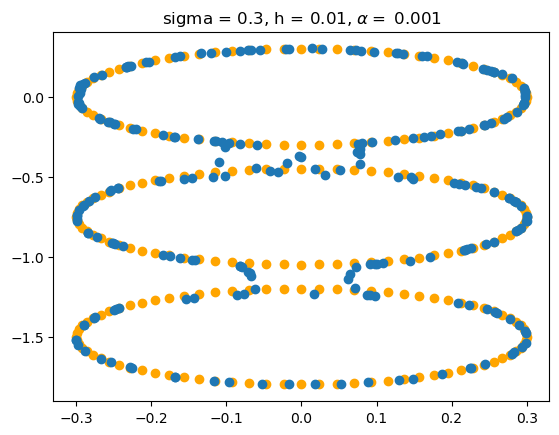

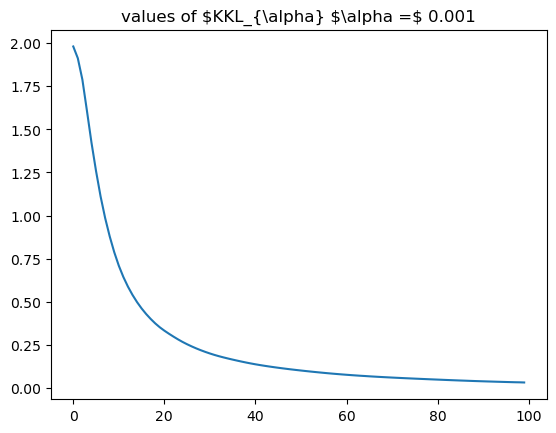

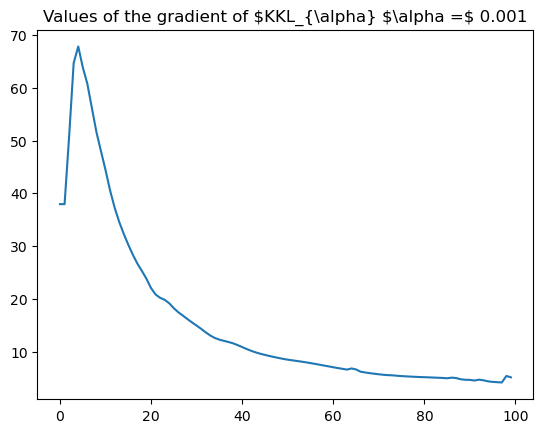

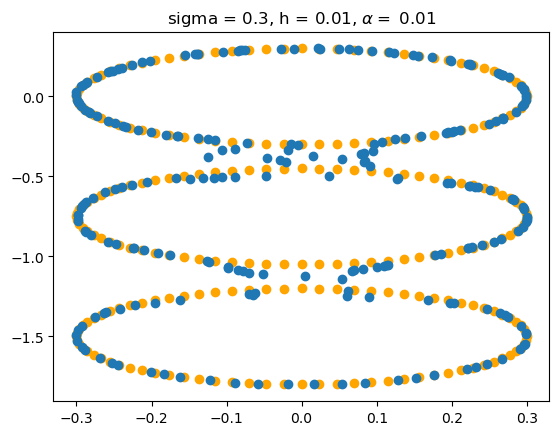

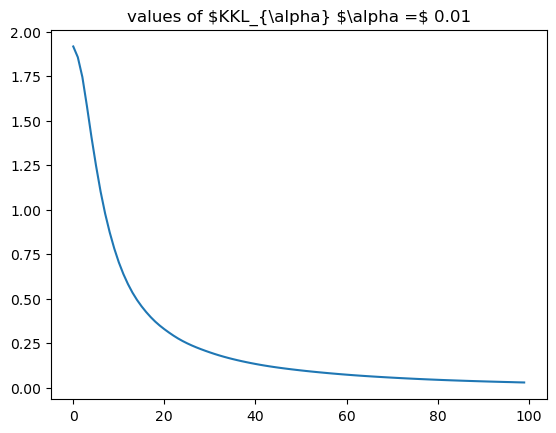

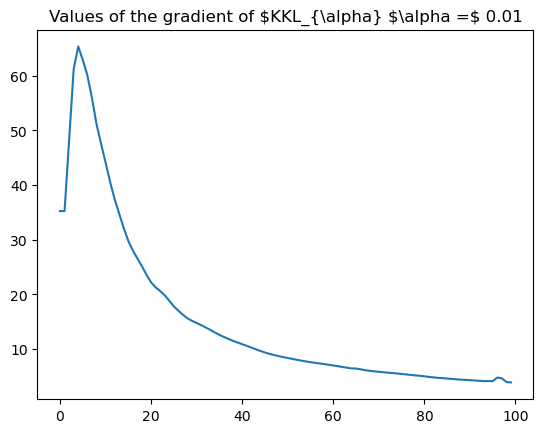

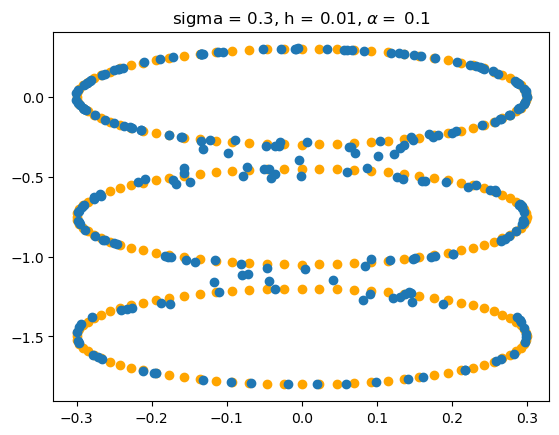

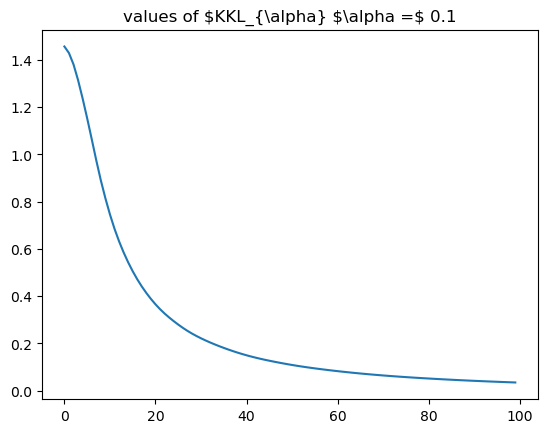

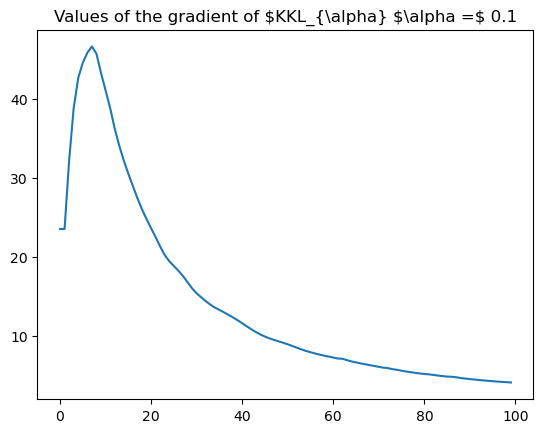

In [60]:
import kkl.divergences as dv
import kkl.kernels as kl
import kkl.gradient_descent as gd
import kkl.generate_y as gy
import cProfile
import time

##############################
######## PARAMETERS ##########
##############################

n = len(x)
m = len(y)
T = 100 # nombre d'itérations
h = 0.01 # stepsize gradient descent
eps = 0.0001
Alpha = [0.001,0.01,0.1]

for alpha in Alpha:
    #### DIVERGENCE ####
    x0 = x
    J = lambda x : dv.KKL(x, y, k, Packy, alpha) 
    dJ = lambda x : dv.WGrad_KKL(x, y, k, dk, Packy, alpha, sigma) 



    ###########################################
    ############ GRADIENT DESCENT #############
    ###########################################


    t0 = time.time()
    X,l_J,Grad = gd.gradient_descent(J, dJ, x0, h, eps, T)
    print("total time : " + str(time.time()-t0))
    
    name_X = 'kkl_3rings_alpha_'+str(alpha)+'_particles.npy'
    np.save('save_data/3_rings/'+name_X, X)
    name_L = 'kkl_3rings_alpha_'+str(alpha)+'KKL.npy'
    np.save('save_data/3_rings/'+name_L, l_J)
    ############################
    ########## PLOTS ###########
    ############################

#     fig, axs = plt.subplots(5, 4, figsize=(20,20))
#     for i in range(0,len(X)-1,T//20):
#         j = i//(T//20)
#         #axs[j//4,j%4].axis([-3,3.5,-4,1])
#         axs[j//4,j%4].scatter(y[:,0],y[:,1],color = "orange")
#         axs[j//4,j%4].scatter(X[i,:,0], X[i,:,1], color = "blue")


    plt.figure()  
    #plt.axis([-3,3.5,-4,1])
    plt.scatter(y[:,0],y[:,1],color = "orange")  
    plt.scatter(X[-1,:,0], X[-1,:,1])
    plt.title("sigma = " + str(sigma) + ", h = " + str(h) + r", $\alpha =$ " + str(alpha))




    plt.figure()    
    plt.plot(l_J)
    plt.title(r"values of $KKL_{\alpha}"+ r" $\alpha =$ " + str(alpha))

    plt.figure()
    plt.plot(Grad)
    plt.title(r"Values of the gradient of $KKL_{\alpha}" + r" $\alpha =$ " + str(alpha))

In [61]:
X_0_001 = np.load('save_data/3_rings/kkl_3rings_alpha_'+str(0.001)+'_particles.npy')
L_0_001 = np.load('save_data/3_rings/kkl_3rings_alpha_'+str(0.001)+'KKL.npy')

X_0_01 = np.load('save_data/3_rings/kkl_3rings_alpha_'+str(0.01)+'_particles.npy')
L_0_01 = np.load('save_data/3_rings/kkl_3rings_alpha_'+str(0.01)+'KKL.npy')

X_0_1 = np.load('save_data/3_rings/kkl_3rings_alpha_'+str(0.1)+'_particles.npy')
L_0_1 = np.load('save_data/3_rings/kkl_3rings_alpha_'+str(0.1)+'KKL.npy')


# Plots

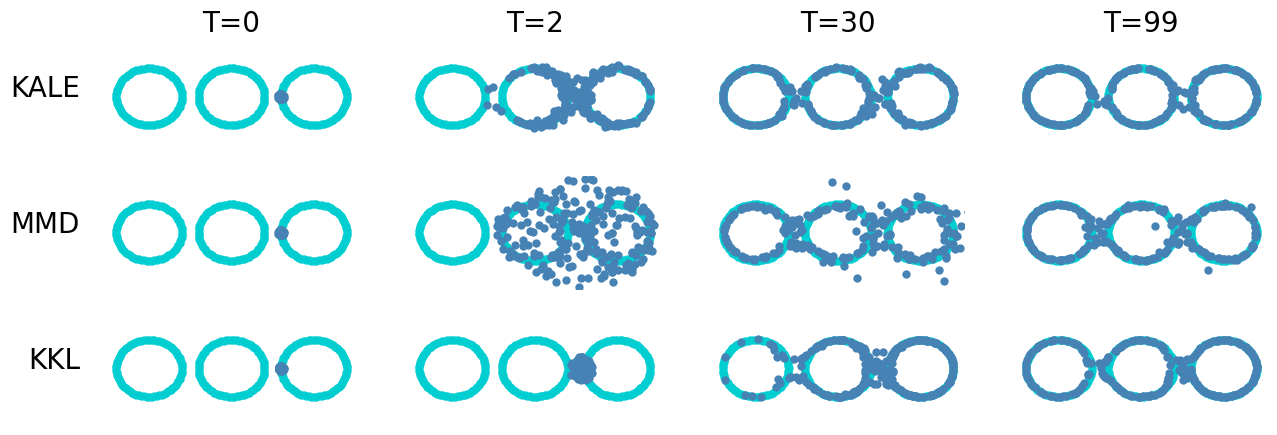

In [75]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 5))
    
iters = [0, 2, 30, 99]

axs[0,0].text(-0.1, 0.5, "KALE", size=20, transform=axs[0,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[0]):
    ax.set_title(f'T={it}')
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(results["kale_0001"]['X'][:, 1], results["kale_0001"]['X'][:, 0],color = "darkturquoise",linewidths=1e-5)
    ax.scatter(results["kale_0001"]['trajectories'][it, :, 1], results["kale_0001"]['trajectories'][it, :, 0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    
axs[1,0].text(-0.1, 0.5, "MMD", size=20, transform=axs[1,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[1]):
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(results["kale_10000"]['X'][:, 1], results["kale_10000"]['X'][:, 0],color = "darkturquoise",linewidths=1e-5)
    ax.scatter(results["kale_10000"]['trajectories'][it, :, 1], results["kale_10000"]['trajectories'][it, :, 0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    
axs[2,0].text(-0.1, 0.5, "KKL", size=20, transform=axs[2,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[2]):
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(y[:,1],y[:,0],color = "darkturquoise",linewidths=1e-5)
    #ax.scatter(positions[it][:,1],positions[it][:,0],color = "steelblue")
    ax.scatter(X_0_01[it][:,1],X_0_01[it][:,0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    

    
output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, '3rings_alpha_0_01.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
    
plt.savefig(output_path,dpi = 300)
    

        

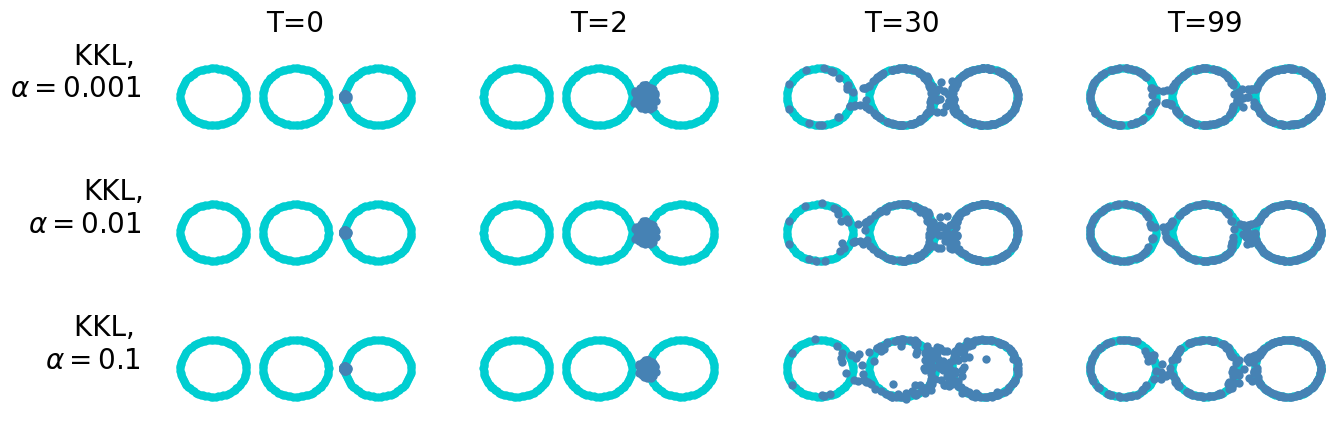

In [93]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 5))
    
iters = [0, 2, 30, 99]

axs[0,0].text(-0.1, 0.5, "KKL, \n" +  r"$\alpha = 0.001$ ", size=20, transform=axs[0,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[0]):
    ax.set_title(f'T={it}')
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(y[:,1],y[:,0],color = "darkturquoise",linewidths=1e-5)
    #ax.scatter(positions[it][:,1],positions[it][:,0],color = "steelblue")
    ax.scatter(X_0_001[it][:,1],X_0_001[it][:,0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    
axs[1,0].text(-0.1, 0.5, "KKL,\n" +  r"$\alpha = 0.01$ ", size=20, transform=axs[1,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[1]):
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(y[:,1],y[:,0],color = "darkturquoise",linewidths=1e-5)
    #ax.scatter(positions[it][:,1],positions[it][:,0],color = "steelblue")
    ax.scatter(X_0_01[it][:,1],X_0_01[it][:,0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    
axs[2,0].text(-0.1, 0.5, "KKL, \n" +  r"$\alpha = 0.1$ ", size=20, transform=axs[2,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[2]):
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(y[:,1],y[:,0],color = "darkturquoise",linewidths=1e-5)
    #ax.scatter(positions[it][:,1],positions[it][:,0],color = "steelblue")
    ax.scatter(X_0_1[it][:,1],X_0_1[it][:,0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')

    
output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, 'comparaison_alpha.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
    
plt.savefig(output_path,dpi = 300)

# Comparison of Wasserstein distance for different $\alpha$

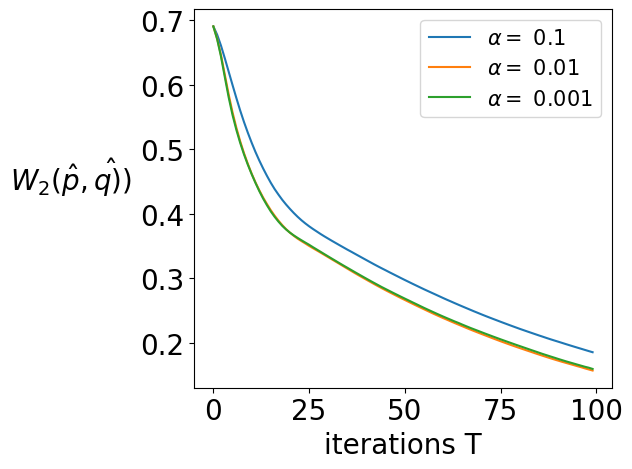

In [90]:
W2 = np.zeros(((3,T)))
for t in range(T):
    b = np.ones((len(y),)) / len(y)
    
    a = np.ones((len(X_0_1[t]),)) / len(X_0_1[t])
    M = ot.dist(X_0_1[t],y,metric = "euclidean")
    W2[0,t] = ot.emd2(a, b, M)
    
    a = np.ones((len(X_0_01[t]),)) / len(X_0_01[t])
    M = ot.dist(X_0_01[t],y,metric = "euclidean")
    W2[1,t] = ot.emd2(a, b, M)
    
    a = np.ones((len(X_0_001[t]),)) / len(X_0_001[t])
    M = ot.dist(X_0_001[t],y,metric = "euclidean")
    W2[2,t] = ot.emd2(a, b, M)

plt.plot(W2[0],label = r"$\alpha = $ " + str(0.1))
plt.plot(W2[1],label = r"$\alpha = $ " + str(0.01))
plt.plot(W2[2],label = r"$\alpha = $ " + str(0.001))
plt.xlabel("iterations T")
plt.ylabel(r"$W_2(\hat{p},\hat{q)})$",labelpad=50, rotation=0)
plt.legend()
plt.tight_layout()

output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, 'wasserstein_kkl.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
    
plt.savefig(output_path,dpi = 200)

# Comparison of Wasserstein distance for different $\alpha$

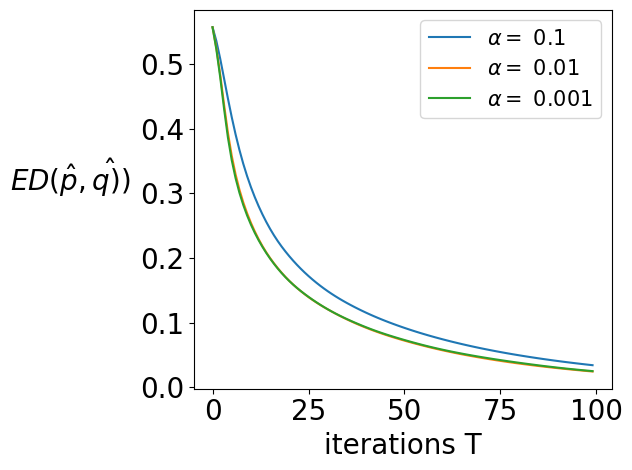

In [92]:
ED = np.zeros(((3,T)))
for t in range(T):
    
    ED[0,t] = dv.energy_distance(X_0_1[t],y)
    
    ED[1,t] = dv.energy_distance(X_0_01[t],y)
    
    ED[2,t] = dv.energy_distance(X_0_001[t],y)

plt.plot(ED[0],label = r"$\alpha = $ " + str(0.1))
plt.plot(ED[1],label = r"$\alpha = $ " + str(0.01))
plt.plot(ED[2],label = r"$\alpha = $ " + str(0.001))
plt.xlabel("iterations T")
plt.ylabel(r"$ED(\hat{p},\hat{q)})$",labelpad=50, rotation=0)
plt.legend()
plt.tight_layout()

output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, 'ED_kkl.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
    
plt.savefig(output_path,dpi = 200)

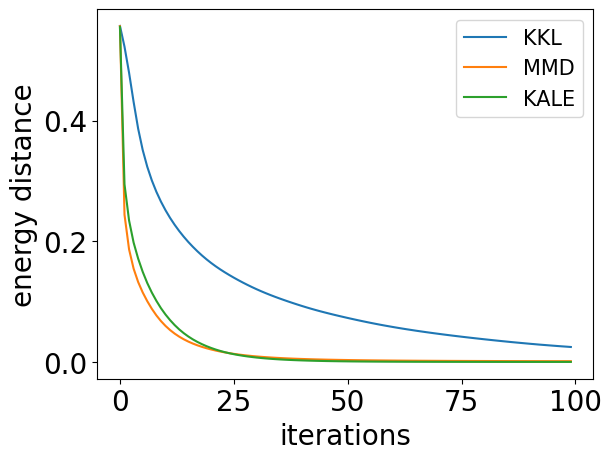

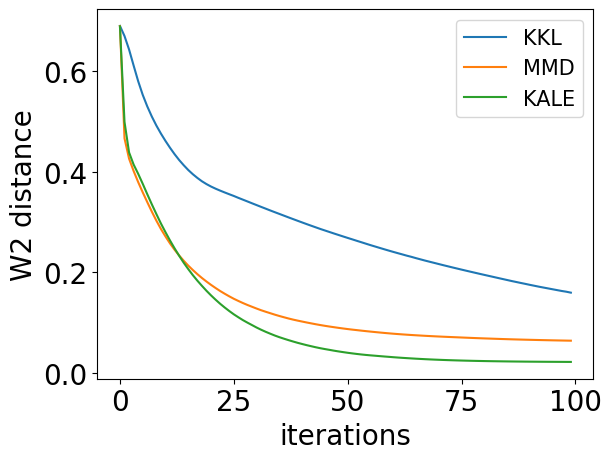

In [97]:
ED_mmd = []
ED_kale = []
ED_kkl = []
for t in range(100):
    x_t = X_0_001[t]
    ED_kkl.append(dv.energy_distance(x_t,y))
    ED_mmd.append(dv.energy_distance(results["kale_10000"]['trajectories'][t],results["kale_10000"]['X']))
    ED_kale.append(dv.energy_distance(results["kale_0001"]['trajectories'][t],results["kale_0001"]['X']))
    
plt.figure()
plt.plot(ED_kkl,label = "KKL" ) 
plt.plot(ED_mmd,label = "MMD" )
plt.plot(ED_kale, label = "KALE")
plt.xlabel("iterations")
plt.ylabel("energy distance")
plt.legend()


Wass2_mmd = []
Wass2_kale = []
Wass2_kkl = []
for t in range(100):
    x_t = X_0_001[t]
    a = np.ones((len(x_t),)) / len(x_t)
    b = np.ones((len(y),)) / len(y)
    M = ot.dist(x_t,y,metric = "euclidean")
    Wass2_kkl.append(ot.emd2(a, b, M))
    
    a = np.ones((len(results["kale_10000"]['trajectories'][t]),)) / len(results["kale_10000"]['trajectories'][t])
    b = np.ones((len(results["kale_10000"]['X']),)) / len(results["kale_10000"]['X'])
    M = ot.dist(results["kale_10000"]['trajectories'][t],results["kale_10000"]['X'],metric = "euclidean")
    Wass2_mmd.append(ot.emd2(a, b, M))
    
    a = np.ones((len(results["kale_0001"]['trajectories'][t]),)) / len(results["kale_0001"]['trajectories'][t])
    b = np.ones((len(results["kale_0001"]['X']),)) / len(results["kale_0001"]['X'])
    M = ot.dist(results["kale_0001"]['trajectories'][t],results["kale_0001"]['X'],metric = "euclidean")
    Wass2_kale.append(ot.emd2(a, b, M))
    
    
plt.figure()
plt.plot(Wass2_kkl,label = "KKL" ) 
plt.plot(Wass2_mmd,label = "MMD" )
plt.plot(Wass2_kale, label = "KALE")
plt.xlabel("iterations")
plt.ylabel("W2 distance")
plt.legend()
    
    

    
    

In [30]:
# df_resultats_kkl = pd.DataFrame({"expe" : ["3 rings"], "alpha" : [alpha], "sigma" : [sigma], "n": [240], "m": [240], "maxiter" : [100], "y" : [y], "x_fin" : [x_fin], "positions" : [positions], "l_J" : [l_J]})
# df_results_kale = pd.DataFrame({"_gf_default_kwargs" : _gf_default_kwargs,"_kale_default_kwargs" : _kale_default_kwargs, "results" : results})
# df_resultats_kkl.to_csv('resultats_kkl', index=False)
# df_results_kale.to_csv('results_kale', index=False)